In [1]:
# import matplotlib
# matplotlib.use('Agg')

import matplotlib as mpl
from matplotlib.pyplot import *
import matplotlib.pyplot as plt

import numpy as np
import os, glob
import datetime
from netCDF4 import Dataset
from collections import namedtuple
from data import anomaly,global_average
from scipy import stats

In [2]:
def colorplot(ax):
    
    almost_black = '#262626' # tweek from Thorsten
    
    for spx in ['bottom','left']:
            ax.spines[spx].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('right')
    ax.xaxis.set_ticks_position('top')
    
    # set axis positions
    ax.yaxis.set_label_position('right') 
    ax.xaxis.set_label_position('top') 
    
    for spx in ['top','right']:
        ax.spines[spx].set_linewidth(0.5)
        ax.spines[spx].set_color(almost_black)
    
    for ticks in ax.xaxis.get_ticklines() + ax.yaxis.get_ticklines():
        ticks.set_color(almost_black)

Calculation using annual average values

In [3]:
modelRun = namedtuple('pfile', ('t', 'ts','t_trop','ts_trop','flux','lwclr','swclr','lwcre','swcre','lw','sw','time'))

# get names of models
fn=glob.glob('cmip5/*.{}.nc'.format('piControl'))
models=[ii.split('/')[1] for ii in fn]
models=[ii.split('.')[0] for ii in models]
models.sort()
models.remove(models[7])

feedbacks={}
for mn in models:
	## read nc file
	with Dataset('cmip5/{0}.{1}.nc'.format(mn,'abrupt4xCO2')) as fni:
		ovar=[]
		for ii in ['flux','ta','tas','t_trop','tas_trop','rlutcs','rsutcs','rlut','rsut','rsdt']:
			try:
				ovar.append(fni[ii][:].squeeze())
				ovar[-1]=ovar[-1][:len(ovar[-1])//12*12]
				ovar[-1]=ovar[-1].reshape(len(ovar[-1])//12,12).mean(axis=1) # annual average
			except IndexError:
				ovar.append(np.array([0]))
			# ovar[-1]=ovar[-1].reshape(len(ovar[-1])/12,12).mean(axis=1) # annual average
			# ovar[-1]=ovar[-1][:80]
    
	feedbacks[mn]=modelRun(flux=ovar[0],t=ovar[1],ts=ovar[2],t_trop=ovar[3],ts_trop=ovar[4],lwclr=-ovar[5],\
		swclr=ovar[9]-ovar[6],lwcre=-(ovar[7]-ovar[5]),swcre=ovar[9]-ovar[8]-(ovar[9]-ovar[6]),\
		sw=ovar[9]-ovar[8],lw=-ovar[7],time=np.arange(len(ovar[0])))

	print('{} '.format(mn),end="")
	sys.stdout.flush()

print()

ACCESS1-0 ACCESS1-3 BCC-CSM1-1 BCC-CSM1-1-M CCSM4 CNRM-CM5 CNRM-CM5-2 CanESM2 FGOALS-g2 FGOALS-s2 GFDL-CM3 GFDL-ESM2G GFDL-ESM2M GISS-E2-H GISS-E2-R HadGEM2-ES INMCM4 IPSL-CM5A-LR IPSL-CM5A-MR IPSL-CM5B-LR MIROC-ESM MIROC5 MPI-ESM-LR MPI-ESM-MR MPI-ESM-P MRI-CGCM3 NorESM1-M 


In [44]:
syear=10

# for fluxvar in 'lwclr,swclr,lwcre,swcre,lw,sw,flux'.split(','):
modelOutput={}
for fluxvar in ['flux']:
	modelOutput[fluxvar]={}
	for mn in models:
		## analyze the run
		mod1=feedbacks[mn] 
		abrupt=[];exec('flux=mod1.{}'.format(fluxvar))
		for tg in [feedbacks[mn].ts,feedbacks[mn].t_trop]:
			# flux=mod1.lwclr+mod1.swclr+mod1.swcre+mod1.lwcre
			
			a1=[stats.linregress(anomaly(tg),anomaly(flux)).slope]
			a1.append(stats.linregress(anomaly(tg[syear:(syear+20)]),anomaly(flux[syear:(syear+20)])).slope)
			a1.append(stats.linregress(anomaly(tg[(syear+20):]),anomaly(flux[(syear+20):])).slope)
			abrupt.append(a1)
		modelOutput[fluxvar][mn]=abrupt

flux  0.50  0.16  0.71  0.34


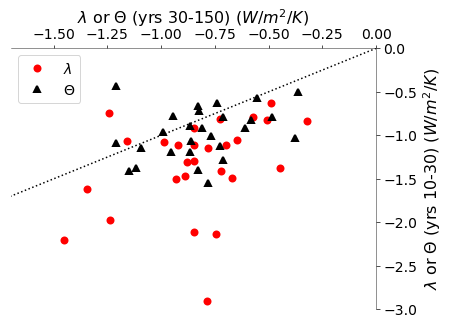

In [45]:
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

# plot of curvature
# for fluxvar in 'lwclr,swclr,lwcre,swcre,flux'.split(','):
fluxvar='flux'
figure(figsize=(7,5))
plt.subplots_adjust(right=0.85,top=0.85)
values4=np.array([modelOutput[fluxvar][ii][0][1] for ii in models])
values5=np.array([modelOutput[fluxvar][ii][0][2] for ii in models])
plot(values5,values4,'ro',label='$\lambda$',markersize=8,markeredgecolor='none')
values6=np.array([modelOutput[fluxvar][ii][1][1] for ii in models])
values7=np.array([modelOutput[fluxvar][ii][1][2] for ii in models])
plot(values7,values6,'k^',markersize=6,mew=2,label='$\Theta$')
plot(np.linspace(-3,3),np.linspace(-3,3),'k',ls='dotted')
avgval=np.average(values4+values5+values6+values7)
# 	xlim(avgval-0.8,avgval+0.8);ylim(avgval-1.,avgval+1.)
xlim(-1.7,0);ylim(-3,0)
legend(loc=2,fontsize=14)
# 	grid()
xlabel('$\lambda$ or $\Theta$ (yrs {}-150) ($W/m^2/K$)'.format(syear+20),fontsize=16)
ylabel('$\lambda$ or $\Theta$ (yrs {}-{}) ($W/m^2/K$)'.format(syear,syear+20),fontsize=16)
print('{} {:5.2f} {:5.2f} {:5.2f} {:5.2f}'.format(fluxvar,np.average(np.array(values5)-np.array(values4)),\
    np.average(np.array(values7)-np.array(values6)),np.average((np.array(values5)-np.array(values4))**2)**0.5,\
    np.average((np.array(values7)-np.array(values6))**2)**0.5))
colorplot(gca())
# savefig('fig6.eps')
# savefig('fig6')

### more calculations

calculation using monthly average values

In [6]:
modelRun = namedtuple('pfile', ('t', 'ts','t_trop','ts_trop','flux','lwclr','swclr','lwcre','swcre','lw','sw','time'))

# get names of models
fn=glob.glob('cmip5/*.{}.nc'.format('piControl'))
models=[ii.split('/')[1] for ii in fn]
models=[ii.split('.')[0] for ii in models]
models.sort()
models.remove(models[7])

feedbacks={}
for mn in models:
	## read nc file
	with Dataset('cmip5/{0}.{1}.nc'.format(mn,'abrupt4xCO2')) as fni:
		ovar=[]
		for ii in ['flux','ta','tas','t_trop','tas_trop','rlutcs','rsutcs','rlut','rsut','rsdt']:
			try:
				ovar.append(fni[ii][:].squeeze())
				ovar[-1]=ovar[-1][:len(ovar[-1])//12*12]
			except IndexError:
				ovar.append(np.array([0]))
    
	feedbacks[mn]=modelRun(flux=ovar[0],t=0,ts=ovar[2],t_trop=ovar[3],ts_trop=0,lwclr=-ovar[5],\
		swclr=ovar[9]-ovar[6],lwcre=-(ovar[7]-ovar[5]),swcre=ovar[9]-ovar[8]-(ovar[9]-ovar[6]),\
		sw=ovar[9]-ovar[8],lw=-ovar[7],time=np.arange(len(ovar[0])))

	print('{} '.format(mn),end="")
	sys.stdout.flush()

print()

ACCESS1-0 ACCESS1-3 BCC-CSM1-1 BCC-CSM1-1-M CCSM4 CNRM-CM5 CNRM-CM5-2 CanESM2 FGOALS-g2 FGOALS-s2 GFDL-CM3 GFDL-ESM2G GFDL-ESM2M GISS-E2-H GISS-E2-R HadGEM2-ES INMCM4 IPSL-CM5A-LR IPSL-CM5A-MR IPSL-CM5B-LR MIROC-ESM MIROC5 MPI-ESM-LR MPI-ESM-MR MPI-ESM-P MRI-CGCM3 NorESM1-M 


In [7]:
syear=10

# for fluxvar in 'lwclr,swclr,lwcre,swcre,lw,sw,flux'.split(','):
modelOutput={}
for fluxvar in ['flux']:
	modelOutput[fluxvar]={}
	for mn in models:
		## analyze the run
		mod1=feedbacks[mn] 
		abrupt=[];exec('flux=mod1.{}'.format(fluxvar))
		for tg in [feedbacks[mn].ts,feedbacks[mn].t_trop]:
			# flux=mod1.lwclr+mod1.swclr+mod1.swcre+mod1.lwcre
			
			a1=[stats.linregress(anomaly(tg),anomaly(flux)).slope]
			a1.append(stats.linregress(anomaly(tg[syear*12:(syear+20)*12]),anomaly(flux[syear*12:(syear+20)*12])).slope)
			a1.append(stats.linregress(anomaly(tg[(syear+20)*12:]),anomaly(flux[(syear+20)*12:])).slope)
			abrupt.append(a1)
		modelOutput[fluxvar][mn]=abrupt

flux  0.37  0.10  0.49  0.22


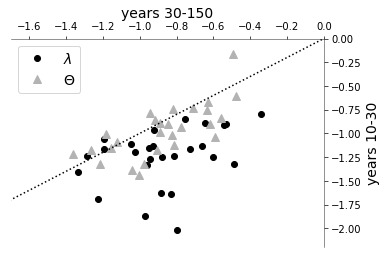

In [9]:
# plot of curvature
# for fluxvar in 'lwclr,swclr,lwcre,swcre,flux'.split(','):
fluxvar='flux'
figure()
plt.subplots_adjust(right=0.85,top=0.85)
values4=np.array([modelOutput[fluxvar][ii][0][1] for ii in models])
values5=np.array([modelOutput[fluxvar][ii][0][2] for ii in models])
plot(values5,values4,'o',color='k',label='$\lambda$')
values6=np.array([modelOutput[fluxvar][ii][1][1] for ii in models])
values7=np.array([modelOutput[fluxvar][ii][1][2] for ii in models])
plot(values7,values6,'^',color='0.7',markersize=8,label='$\Theta$')
plot(np.linspace(-3,3),np.linspace(-3,3),'k',ls='dotted')
avgval=np.average(values4+values5+values6+values7)
# 	xlim(avgval-0.8,avgval+0.8);ylim(avgval-1.,avgval+1.)
xlim(-1.7,0);ylim(-2.2,0)
legend(loc=2,fontsize=14)
# 	grid()
xlabel('years {}-150'.format(syear+20),fontsize=14);ylabel('years {}-{}'.format(syear,syear+20),fontsize=14)
print('{} {:5.2f} {:5.2f} {:5.2f} {:5.2f}'.format(fluxvar,np.average(np.array(values5)-np.array(values4)),\
    np.average(np.array(values7)-np.array(values6)),np.average((np.array(values5)-np.array(values4))**2)**0.5,\
    np.average((np.array(values7)-np.array(values6))**2)**0.5))
colorplot(gca())
# savefig('fig4.eps')

Using global average $T_A$ shows similar curvature to global avg. $T_S$

In [6]:
syear=10

# for fluxvar in 'lwclr,swclr,lwcre,swcre,lw,sw,flux'.split(','):
modelOutput={}
for fluxvar in ['flux']:
	modelOutput[fluxvar]={}
	for mn in models:
		## analyze the run
		mod1=feedbacks[mn] 
		abrupt=[];exec('flux=mod1.{}'.format(fluxvar))
		for tg in [feedbacks[mn].ts_trop,feedbacks[mn].t]:
			# flux=mod1.lwclr+mod1.swclr+mod1.swcre+mod1.lwcre
			
			a1=[stats.linregress(anomaly(tg),anomaly(flux)).slope]
			a1.append(stats.linregress(anomaly(tg[syear*12:(syear+20)*12]),anomaly(flux[syear*12:(syear+20)*12])).slope)
			a1.append(stats.linregress(anomaly(tg[(syear+20)*12:]),anomaly(flux[(syear+20)*12:])).slope)
			abrupt.append(a1)

		modelOutput[fluxvar][mn]=abrupt

flux  0.14  0.26  0.24  0.43


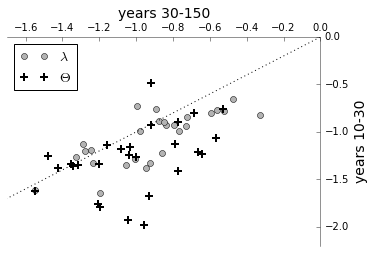

In [7]:
# plot of curvature
# for fluxvar in 'lwclr,swclr,lwcre,swcre,flux'.split(','):
fluxvar='flux'
figure()
plt.subplots_adjust(right=0.85,top=0.85)
values4=np.array([modelOutput[fluxvar][ii][0][1] for ii in models])
values5=np.array([modelOutput[fluxvar][ii][0][2] for ii in models])
plot(values5,values4,'o',color='0.7',label='$\lambda$')
values6=np.array([modelOutput[fluxvar][ii][1][1] for ii in models])
values7=np.array([modelOutput[fluxvar][ii][1][2] for ii in models])
plot(values7,values6,'k+',markersize=8,mew=2,label='$\Theta$')
plot(np.linspace(-3,3),np.linspace(-3,3),'k',ls='dotted')
avgval=np.average(values4+values5+values6+values7)
# 	xlim(avgval-0.8,avgval+0.8);ylim(avgval-1.,avgval+1.)
xlim(-1.7,0);ylim(-2.2,0)
legend(loc=2,fontsize=14)
# 	grid()
xlabel('years {}-150'.format(syear+20),fontsize=14);ylabel('years {}-{}'.format(syear,syear+20),fontsize=14)
print '{} {:5.2f} {:5.2f} {:5.2f} {:5.2f}'.format(fluxvar,np.average(np.array(values5)-np.array(values4)),\
    np.average(np.array(values7)-np.array(values6)),np.average((np.array(values5)-np.array(values4))**2)**0.5,\
    np.average((np.array(values7)-np.array(values6))**2)**0.5)
colorplot(gca())
# savefig('figS6.eps')

look at slope between Ts and Ta

In [34]:
syear=10

# for fluxvar in 'lwclr,swclr,lwcre,swcre,lw,sw,flux'.split(','):
modelOutput={}
modelOutput[fluxvar]={}
for mn in models:
	## analyze the run
	mod1=feedbacks[mn] 
	abrupt=[]

	a1=[stats.linregress(anomaly(feedbacks[mn].t_trop),anomaly(feedbacks[mn].ts)).slope]
	a1.append(stats.linregress(anomaly(feedbacks[mn].t_trop[syear:(syear+20)]),anomaly(feedbacks[mn].ts[syear:(syear+20)])).slope)
	a1.append(stats.linregress(anomaly(feedbacks[mn].t_trop[(syear+20):]),anomaly(feedbacks[mn].ts[(syear+20):])).slope)

	modelOutput[mn]=a1

flux  0.16  0.26  0.25  0.26


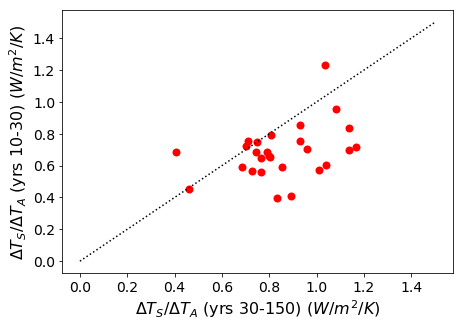

In [43]:
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

# plot of curvature
# for fluxvar in 'lwclr,swclr,lwcre,swcre,flux'.split(','):
figure(figsize=(7,5))
plt.subplots_adjust(bottom=0.15)
values4=np.array([modelOutput[ii][1] for ii in models])
values5=np.array([modelOutput[ii][2] for ii in models])
plot(values5,values4,'ro',label='$\lambda$',markersize=8,markeredgecolor='none')
plot(np.linspace(0,1.5),np.linspace(0,1.5),'k',ls='dotted')
# xlim(-1.7,0);ylim(-3,0)
# legend(loc=2,fontsize=14)
# 	grid()
xlabel('$\Delta T_S/\Delta T_A$ (yrs {}-150) ($W/m^2/K$)'.format(syear+20),fontsize=16)
ylabel('$\Delta T_S/\Delta T_A$ (yrs {}-{}) ($W/m^2/K$)'.format(syear,syear+20),fontsize=16)
print('{} {:5.2f} {:5.2f} {:5.2f} {:5.2f}'.format(fluxvar,np.average(np.array(values5)-np.array(values4)),\
    np.average(np.array(values7)-np.array(values6)),np.average((np.array(values5)-np.array(values4))**2)**0.5,\
    np.average((np.array(values7)-np.array(values6))**2)**0.5))
# colorplot(gca())
savefig('TsTa')

In [25]:
values4

array([[0.85375787, 0.59278276, 0.8549504 ],
       [0.85375787, 0.59278276, 0.8549504 ],
       [0.85375787, 0.59278276, 0.8549504 ],
       [0.85375787, 0.59278276, 0.8549504 ],
       [0.85375787, 0.59278276, 0.8549504 ],
       [0.85375787, 0.59278276, 0.8549504 ],
       [0.85375787, 0.59278276, 0.8549504 ],
       [0.85375787, 0.59278276, 0.8549504 ],
       [0.85375787, 0.59278276, 0.8549504 ],
       [0.85375787, 0.59278276, 0.8549504 ],
       [0.85375787, 0.59278276, 0.8549504 ],
       [0.85375787, 0.59278276, 0.8549504 ],
       [0.85375787, 0.59278276, 0.8549504 ],
       [0.85375787, 0.59278276, 0.8549504 ],
       [0.85375787, 0.59278276, 0.8549504 ],
       [0.85375787, 0.59278276, 0.8549504 ],
       [0.85375787, 0.59278276, 0.8549504 ],
       [0.85375787, 0.59278276, 0.8549504 ],
       [0.85375787, 0.59278276, 0.8549504 ],
       [0.85375787, 0.59278276, 0.8549504 ],
       [0.85375787, 0.59278276, 0.8549504 ],
       [0.85375787, 0.59278276, 0.8549504 ],
       [0.

In [35]:
modelOutput[models[1]]

[0.8537578738240554, 0.5927827550202908, 0.8549504035722414]